<a href="https://colab.research.google.com/github/NinaNikolova/data_mining_project/blob/main/python_games_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mодел за прогнозиране на рейтинги на видео игри
## Mодел за линейна регресия - 2, който предсказва рейтинги на видео игри

In [36]:
from google.colab import drive
drive.mount('/content/drive')
from google.colab import files
uploaded = files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving video_game_reviews.csv to video_game_reviews (2).csv


Импортиране на библиотеки:
- pandas и numpy - за работа с данни и числови операции
- matplotlib и seaborn - за визуализация на данните
- sklearn библиотеки - за създаване на модела за машинно обучение, предварителна обработка на данните и оценка на резултатите

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score

from sklearn.svm import LinearSVC
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import joblib
import warnings
warnings.filterwarnings('ignore')

Зареждане на данните
- Зареждаме данните от CSV файл в променлива df (DataFrame). Тези данни съдържат информация за видео игри и техните рейтинги.
- Използва се Video Game Reviews and Ratings dataset:
https://www.kaggle.com/datasets/jahnavipaliwal/video-game-reviews-and-ratings

In [38]:
df = pd.read_csv('/content/video_game_reviews.csv')
df.head()

,Game Title,User Rating,Age Group Targeted,Price,Platform,Requires Special Device,Developer,Publisher,Release Year,Genre,Multiplayer,Game Length (Hours),Graphics Quality,Soundtrack Quality,Story Quality,User Review Text,Game Mode,Min Number of Players
0,Grand Theft Auto V,36.4,All Ages,41.41,PC,No,Game Freak,Innersloth,2015,Adventure,No,55.3,Medium,Average,Poor,"Solid game, but too many bugs.",Offline,1
1,The Sims 4,38.3,Adults,57.56,PC,No,Nintendo,Electronic Arts,2015,Shooter,Yes,34.6,Low,Poor,Poor,"Solid game, but too many bugs.",Offline,3
2,Minecraft,26.8,Teens,44.93,PC,Yes,Bungie,Capcom,2012,Adventure,Yes,13.9,Low,Good,Average,"Great game, but the graphics could be better.",Offline,5
3,Bioshock Infinite,38.4,All Ages,48.29,Mobile,Yes,Game Freak,Nintendo,2015,Sports,No,41.9,Medium,Good,Excellent,"Solid game, but the graphics could be better.",Online,4
4,Half-Life: Alyx,30.1,Adults,55.49,PlayStation,Yes,Game Freak,Epic Games,2022,RPG,Yes,13.2,High,Poor,Good,"Great game, but too many bugs.",Offline,1


In [39]:
df["User Review Text"].unique()

array(['Solid game, but too many bugs.',
       'Great game, but the graphics could be better.',
       'Solid game, but the graphics could be better.',
       'Great game, but too many bugs.',
       'Solid game, but the gameplay is amazing.',
       'Disappointing game, but the gameplay is amazing.',
       'Great game, but the gameplay is amazing.',
       'Amazing game, but the gameplay is amazing.',
       'Disappointing game, but the graphics could be better.',
       'Amazing game, but too many bugs.',
       'Amazing game, but the graphics could be better.',
       'Disappointing game, but too many bugs.'], dtype=object)

In [40]:
df.loc[df["User Review Text"].str.contains("bugs", case=False, na=False), "User Review Text"] = "bugs"
df.loc[df["User Review Text"].str.contains("gameplay is amazing", case=False, na=False), "User Review Text"] = "amazing gameplay"
df.loc[df["User Review Text"].str.contains("the graphics could be better", case=False, na=False), "User Review Text"] = "bad graphics"

In [41]:
df["User Review Text"].unique()

array(['bugs', 'bad graphics', 'amazing gameplay'], dtype=object)

In [42]:
df["Graphics Quality"].unique()

array(['Medium', 'Low', 'High', 'Ultra'], dtype=object)

In [43]:
df["Graphics Quality"] = df["Graphics Quality"].replace({
    "High": "good",
    "Ultra": "good",
    "Medium": "bad",
    "Low": "bad"
})

In [44]:
df["Soundtrack Quality"].unique()

array(['Average', 'Poor', 'Good', 'Excellent'], dtype=object)

In [45]:
df["Soundtrack Quality"] = df["Soundtrack Quality"].replace({
   "Good": "good",
    "Excellent": "good",
    "Average": "bad",
    "Poor": "bad"
})

In [46]:
df_target = df["User Rating"]
columns_to_drop = ['Developer', 'Publisher', 'Game Title', 'Requires Special Device','Age Group Targeted', 'Story Quality', 'Platform']

df= df.drop(columns=columns_to_drop)
df_attributes=pd.get_dummies(df, drop_first=True)

df_attributes.head()


,User Rating,Price,Release Year,Game Length (Hours),Min Number of Players,Genre_Adventure,Genre_Fighting,Genre_Party,Genre_Puzzle,Genre_RPG,Genre_Shooter,Genre_Simulation,Genre_Sports,Genre_Strategy,Multiplayer_Yes,Graphics Quality_good,Soundtrack Quality_good,User Review Text_bad graphics,User Review Text_bugs,Game Mode_Online
0,36.4,41.41,2015,55.3,1,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False
1,38.3,57.56,2015,34.6,3,False,False,False,False,False,True,False,False,False,True,False,False,False,True,False
2,26.8,44.93,2012,13.9,5,True,False,False,False,False,False,False,False,False,True,False,True,True,False,False
3,38.4,48.29,2015,41.9,4,False,False,False,False,False,False,False,True,False,False,False,True,True,False,True
4,30.1,55.49,2022,13.2,1,False,False,False,False,True,False,False,False,False,True,True,False,False,True,False


In [47]:
target_column = 'User Rating'
categorical_columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features = []
for col in categorical_columns:
    if col != target_column and df[col].nunique() < 50:
        categorical_features.append(col)

numeric_features = df.select_dtypes(include=['number']).columns.tolist()
numeric_features = [col for col in numeric_features if col != target_column]

print(f"\nSelected numeric features: {numeric_features}")
print(f"Selected categorical features: {categorical_features}")


Selected numeric features: ['Price', 'Release Year', 'Game Length (Hours)', 'Min Number of Players']
Selected categorical features: ['Genre', 'Multiplayer', 'Graphics Quality', 'Soundtrack Quality', 'User Review Text', 'Game Mode']


Създаване на конвейер за предварителна обработка
- Създаваме конвейери за обработка на различните типове данни:
- За числовите характеристики: попълваме липсващите стойности със средната стойност и стандартизираме данните
- За категоричните характеристики: попълваме липсващите стойности с най-често срещаната стойност и прилагаме one-hot encoding
- Обединяваме тези конвейери в един общ преработвач (preprocessor)

In [48]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])




Създаване на модела
- Създаваме цялостен конвейер, който включва предварителната обработка и линейния регресионен модел
- Това опростява процеса на обучение и предсказване

In [49]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])



Разделяне на данните
- Разделяме данните на характеристики (X) и целева променлива (y)
- Използваме функцията train_test_split за разделяне на данните на тренировъчен (80%) и тестов (20%) набор
- Задаваме random_state=42 за възпроизводимост на резултатите
- Извеждаме размера на получените набори от данни

In [50]:
X = df[numeric_features + categorical_features]
y = df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")



Training set size: (38219, 10)
Testing set size: (9555, 10)


Обучение на модела
- Обучаваме модела върху тренировъчните данни Функцията fit() изпълнява както предварителната обработка, така и обучението на линейния регресионен модел

In [51]:
print("\nTraining the model...")
model.fit(X_train, y_train)



Training the model...


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Price', 'Release Year',
                                                   'Game Length (Hours)',
                                                   'Min Number of Players']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Genre', 'Multiplayer',
                                                   'Graphics Quality',
                                                   'Soundtrack Quality',
                                                   'User Review Text',
                                                   'Game Mode'])])),
                ('regressor', LinearRegression())])

Оценка на модела
- Правим предсказания върху тестовия набор от данни Изчисляваме различни метрики за оценка на точността на модела:
- MSE (средно-квадратична грешка) - по-ниски стойности са по-добри
- RMSE (корен от средно-квадратичната грешка) - в същите единици като целевата променлива
- R² (коефициент на детерминация) - показва каква част от вариацията на данните е обяснена от модела (0-1, по-високи стойности са по-добри)

In [52]:

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Evaluation:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared: {r2:.4f}")


Model Evaluation:
Mean Squared Error: 1.3386
Root Mean Squared Error: 1.1570
R-squared: 0.9769


Визуализация на предсказанията
- Създаваме диаграма, която сравнява действителните рейтинги с предсказаните
- Идеалните предсказания биха лежали на червената пунктирана линия
- Това ни помага визуално да оценим колко добре работи моделът

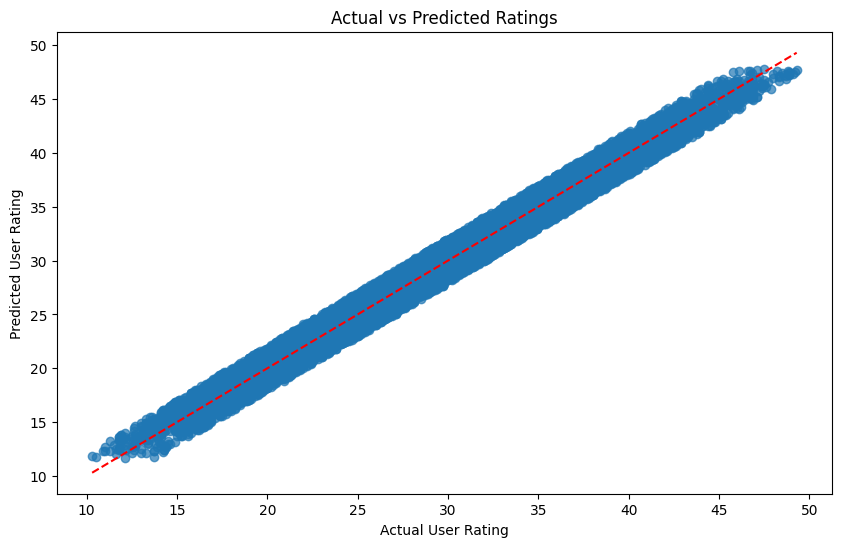

In [53]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel(f'Actual {target_column}')
plt.ylabel(f'Predicted {target_column}')
plt.title('Actual vs Predicted Ratings')
plt.show()  # This will display the plot directly in the Colab output

Анализ на остатъците
- Изчисляваме остатъците (разликата между действителните и предсказани стойности)
- Визуализираме разпределението на остатъците - в идеалния случай те трябва да имат нормално разпределение около нулата
- Създаваме диаграма на остатъците спрямо предсказаните стойности - в идеалния случай не трябва да се наблюдават систематични модели

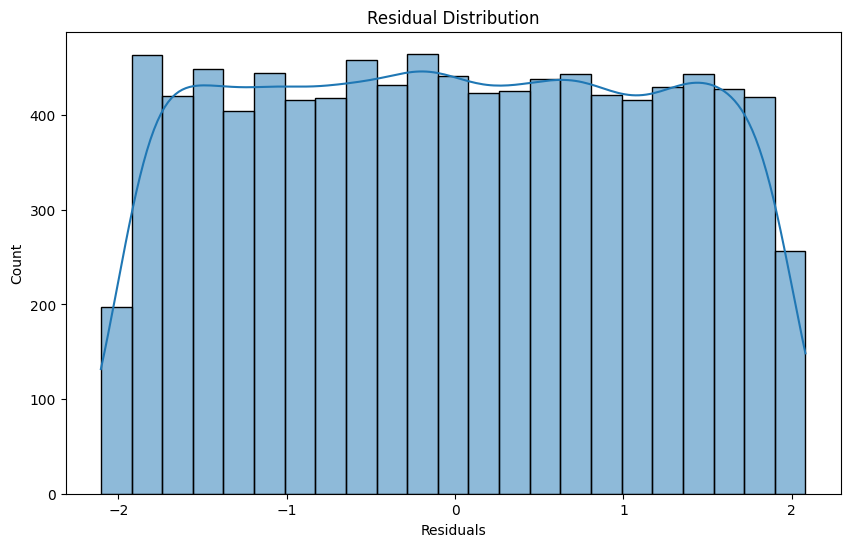

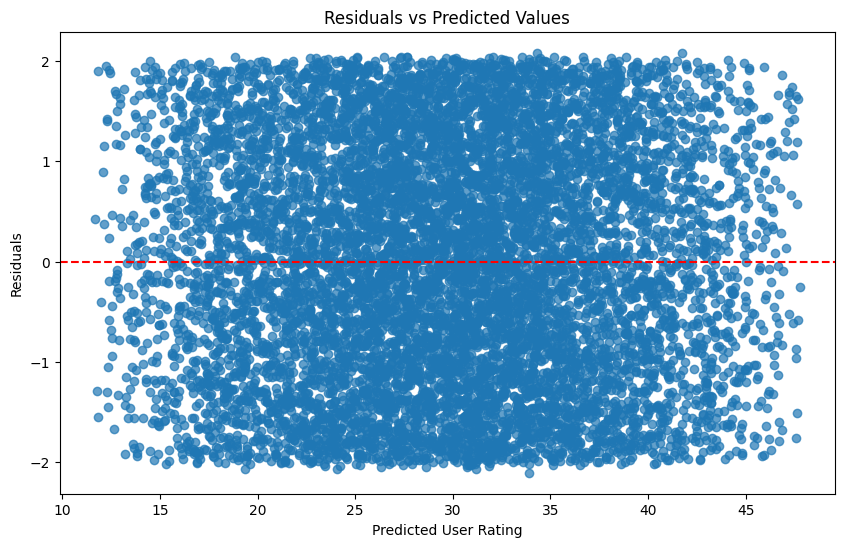

In [54]:
# Residuals
residuals = y_test - y_pred

# Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Residual Distribution')
plt.show()  # Show in Colab

# Residuals vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel(f'Predicted {target_column}')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()  # Show in Colab

Анализ на важността на характеристиките
Извличаме и анализираме коефициентите на линейния регресионен модел
Коефициентите показват относителната важност на всяка характеристика за предсказването на рейтингите
Извеждаме топ 10 характеристики с най-голямо абсолютно влияние

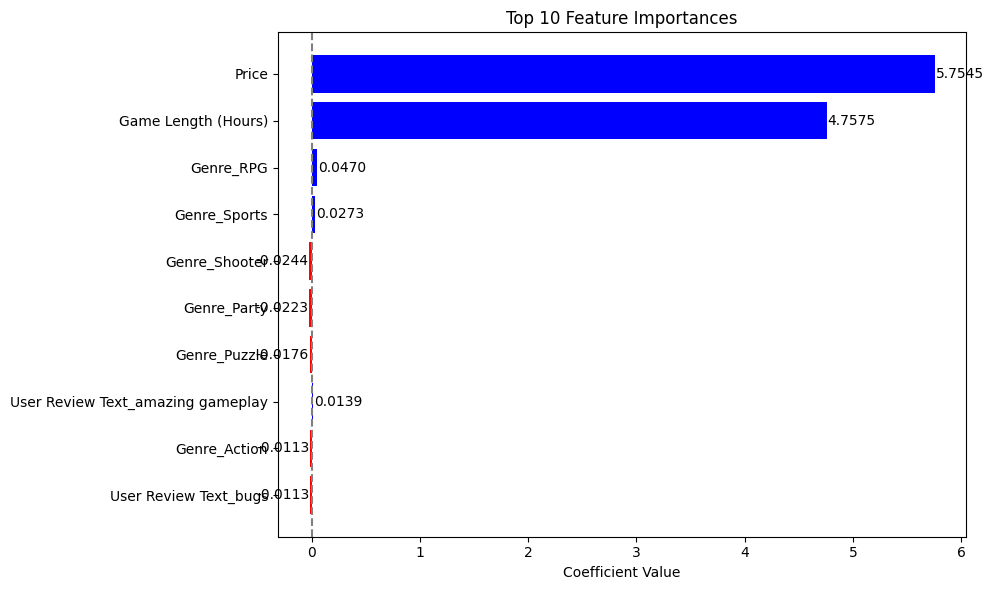

In [60]:
if len(numeric_features) > 0:
    try:
        regressor = model.named_steps['regressor']
        preprocessor = model.named_steps['preprocessor']

        # Combine feature names
        feature_names = []
        if len(numeric_features) > 0:
            feature_names.extend(numeric_features)
        if len(categorical_features) > 0:
            cat_features = preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)
            feature_names.extend(cat_features)

        # Get model coefficients
        coef = regressor.coef_

        # Get top 10 absolute coefficients
        sorted_indices = np.argsort(np.abs(coef))[-10:]
        top_features = [feature_names[i] if i < len(feature_names) else f"Index {i}" for i in sorted_indices]
        top_coefficients = coef[sorted_indices]

        # Set colors: red for negative, blue for positive
        colors = ['red' if val < 0 else 'blue' for val in top_coefficients]

        # Plot as bar chart
        plt.figure(figsize=(10, 6))
        bars = plt.barh(top_features, top_coefficients, color=colors)
        plt.xlabel('Coefficient Value')
        plt.title('Top 10 Feature Importances')
        plt.axvline(x=0, color='gray', linestyle='--')

        # Annotate bars with coefficient values
        for bar, value in zip(bars, top_coefficients):
            plt.text(
                x=value + 0.01 if value >= 0 else value - 0.01,
                y=bar.get_y() + bar.get_height() / 2,
                s=f"{value:.4f}",
                va='center',
                ha='left' if value >= 0 else 'right',
                fontsize=10,
                color='black'
            )

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not extract feature importance: {e}")